<a href="https://colab.research.google.com/github/i-osipchyk/insurance-cross-selling/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Ingestion

If using Google Colab, upload kaggle.json file to the environment. Then run these commands:

In [3]:
%cd /
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
%cd content
!kaggle competitions download -c playground-series-s4e7
!unzip playground-series-s4e7.zip
!rm playground-series-s4e7.zip

/
/content
 94% 232M/247M [00:01<00:00, 238MB/s]
100% 247M/247M [00:01<00:00, 229MB/s]
Archive:  playground-series-s4e7.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## EDA

### Data Description

In [5]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
print('Shape of the training data:', train.shape)
print('Shape of the testing data:', test.shape)

Shape of the training data: (11504798, 12)
Shape of the testing data: (7669866, 11)


In [8]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


Let's drop id column from training set and save it from testing set, because we are not going to use them for the predictions.

In [7]:
train.drop('id', axis=1, inplace=True)
test_id = test['id']
test.drop('id', axis=1, inplace=True)

In [10]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Feature Distributions

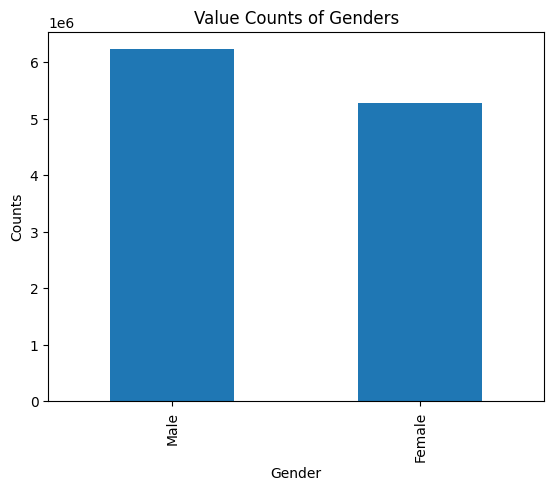

In [16]:
train['Gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Value Counts of Genders')
plt.show()

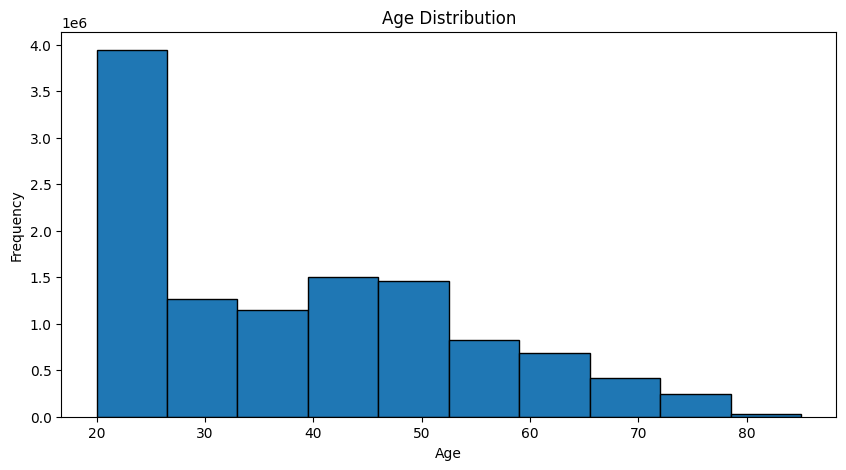

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(train['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

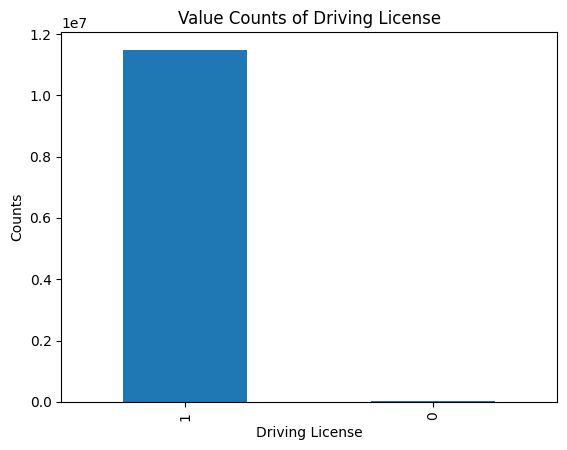

In [18]:
train['Driving_License'].value_counts().plot(kind='bar')
plt.xlabel('Driving License')
plt.ylabel('Counts')
plt.title('Value Counts of Driving License')
plt.show()

Note that number of instances without driving license is very underrepresented.

In [19]:
train['Driving_License'].value_counts()

Driving_License
1    11482041
0       22757
Name: count, dtype: int64

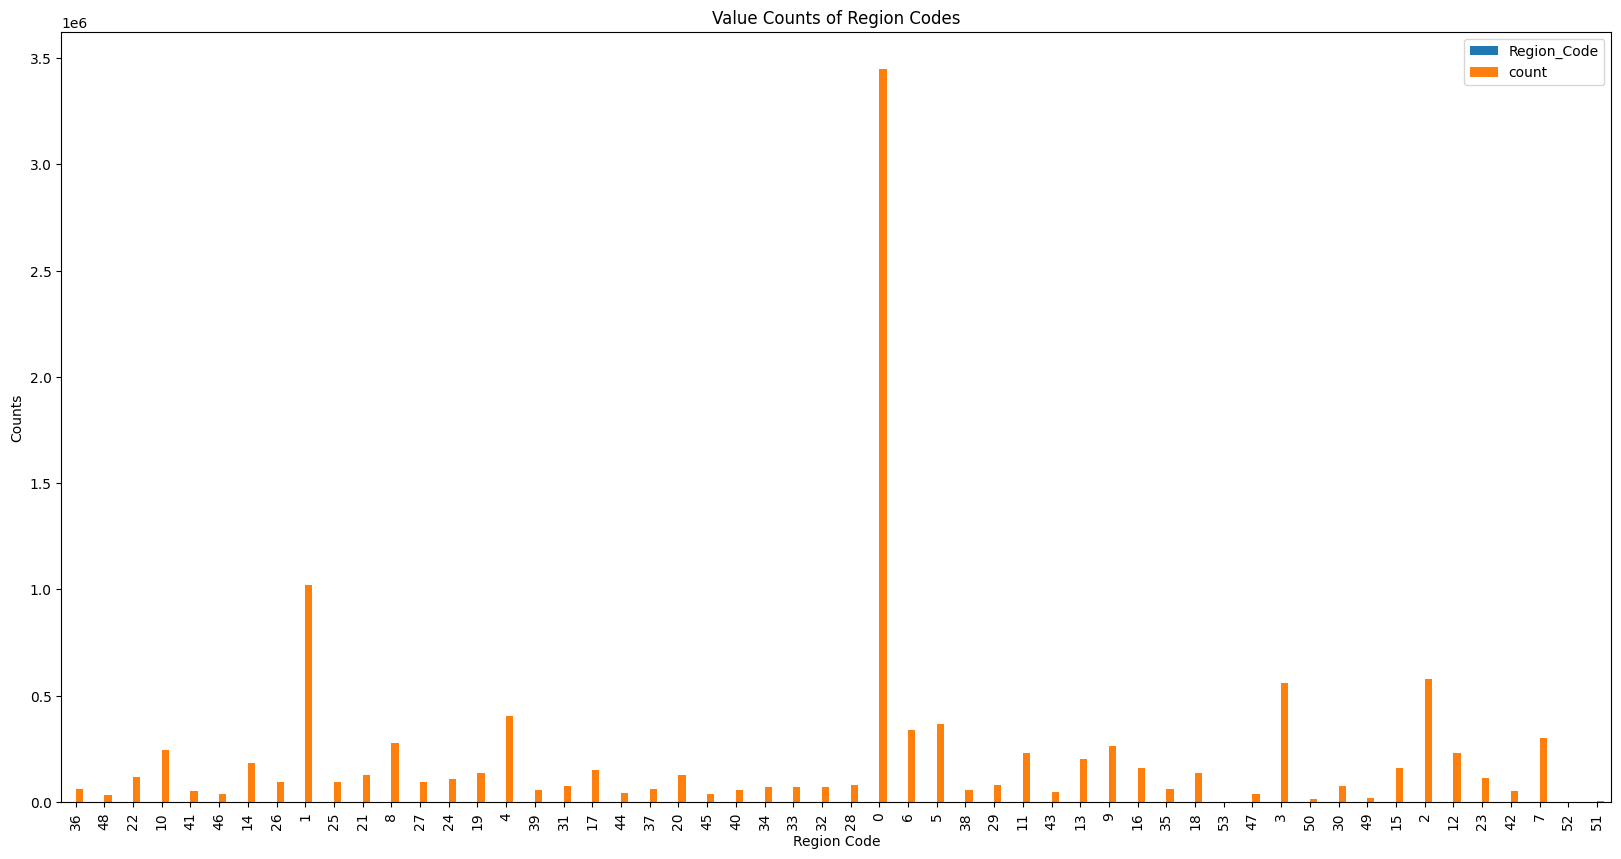

In [20]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
train['Region_Code'].value_counts().reset_index().sort_values(by='Region_Code').plot(kind='bar', ax=ax)
plt.xlabel('Region Code')
plt.ylabel('Counts')
plt.title('Value Counts of Region Codes')
plt.show()

Almost third of instances if from Region with code 0.

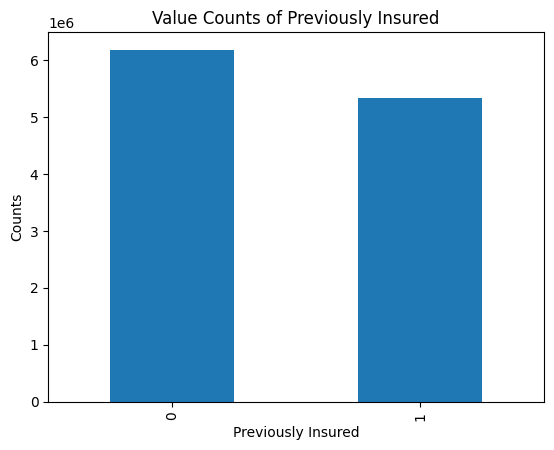

In [21]:
train['Previously_Insured'].value_counts().plot(kind='bar')
plt.xlabel('Previously Insured')
plt.ylabel('Counts')
plt.title('Value Counts of Previously Insured')
plt.show()

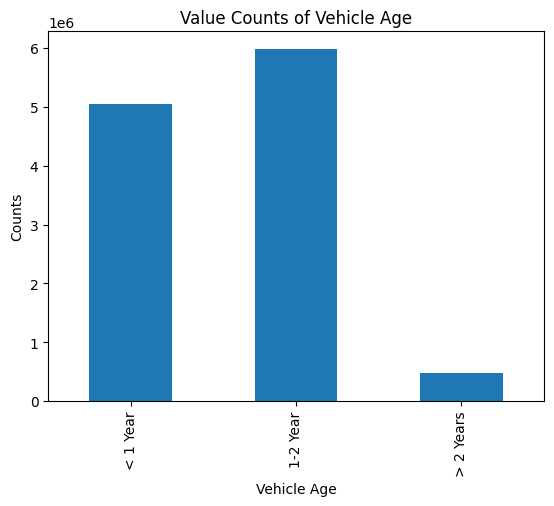

In [22]:
new_order = [1, 0, 2]
v_age_dist = train['Vehicle_Age'].value_counts().reset_index()
v_age_dist['Order'] = new_order
v_age_dist.sort_values(by='Order', ascending=True, inplace=True)
v_age_dist.set_index('Vehicle_Age', inplace=True)
v_age_dist['count'].plot(kind='bar')
plt.xlabel('Vehicle Age')
plt.ylabel('Counts')
plt.title('Value Counts of Vehicle Age')
plt.show()

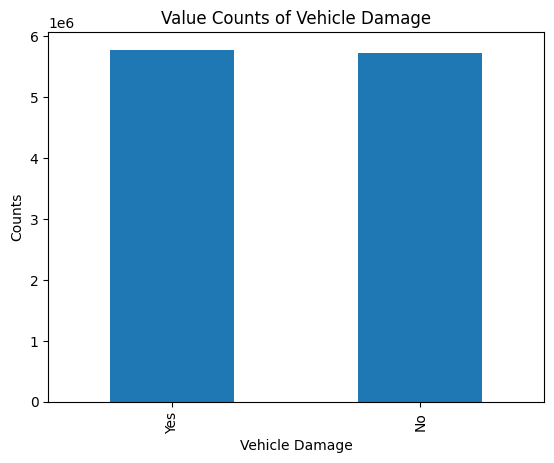

In [23]:
train['Vehicle_Damage'].value_counts().plot(kind='bar')
plt.xlabel('Vehicle Damage')
plt.ylabel('Counts')
plt.title('Value Counts of Vehicle Damage')
plt.show()

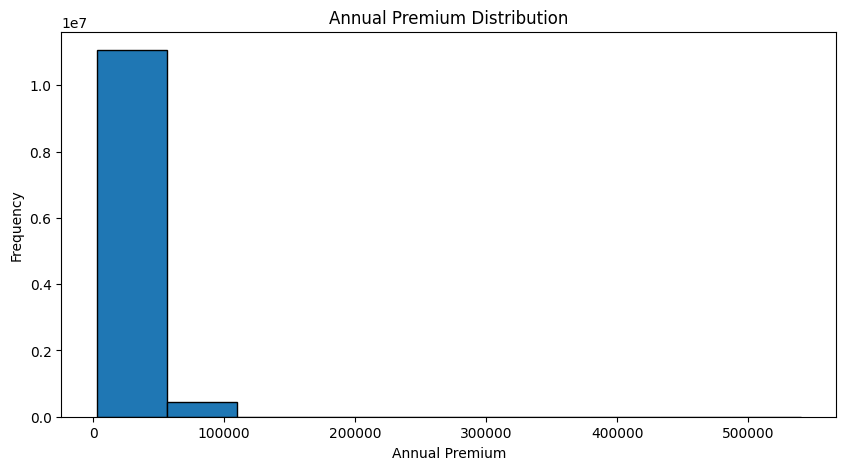

In [24]:
plt.figure(figsize=(10, 5))
plt.hist(train['Annual_Premium'], bins=10, edgecolor='black')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.title('Annual Premium Distribution')
plt.show()

There are some values that are higher than 100000. We can consider them as outliers and delete them Let's check what is their percentage to make sure if it's the right thing to do.

In [25]:
print(
    "Precentage of instances with Annual Premium more than 100000: {:.4f}"
    .format(len(train.query("Annual_Premium > 100000"))/len(train)*100)
    )

Precentage of instances with Annual Premium more than 100000: 0.0201


The percentage is very low, so we will drop them.

In [8]:
train = train[train['Annual_Premium'] <= 100000]

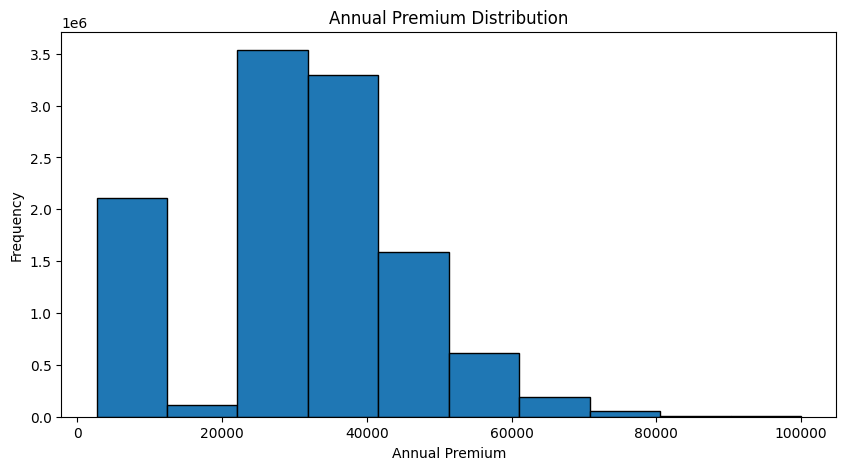

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(train['Annual_Premium'], bins=10, edgecolor='black')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.title('Annual Premium Distribution')
plt.show()

Note a gap between 10000 and 20000.

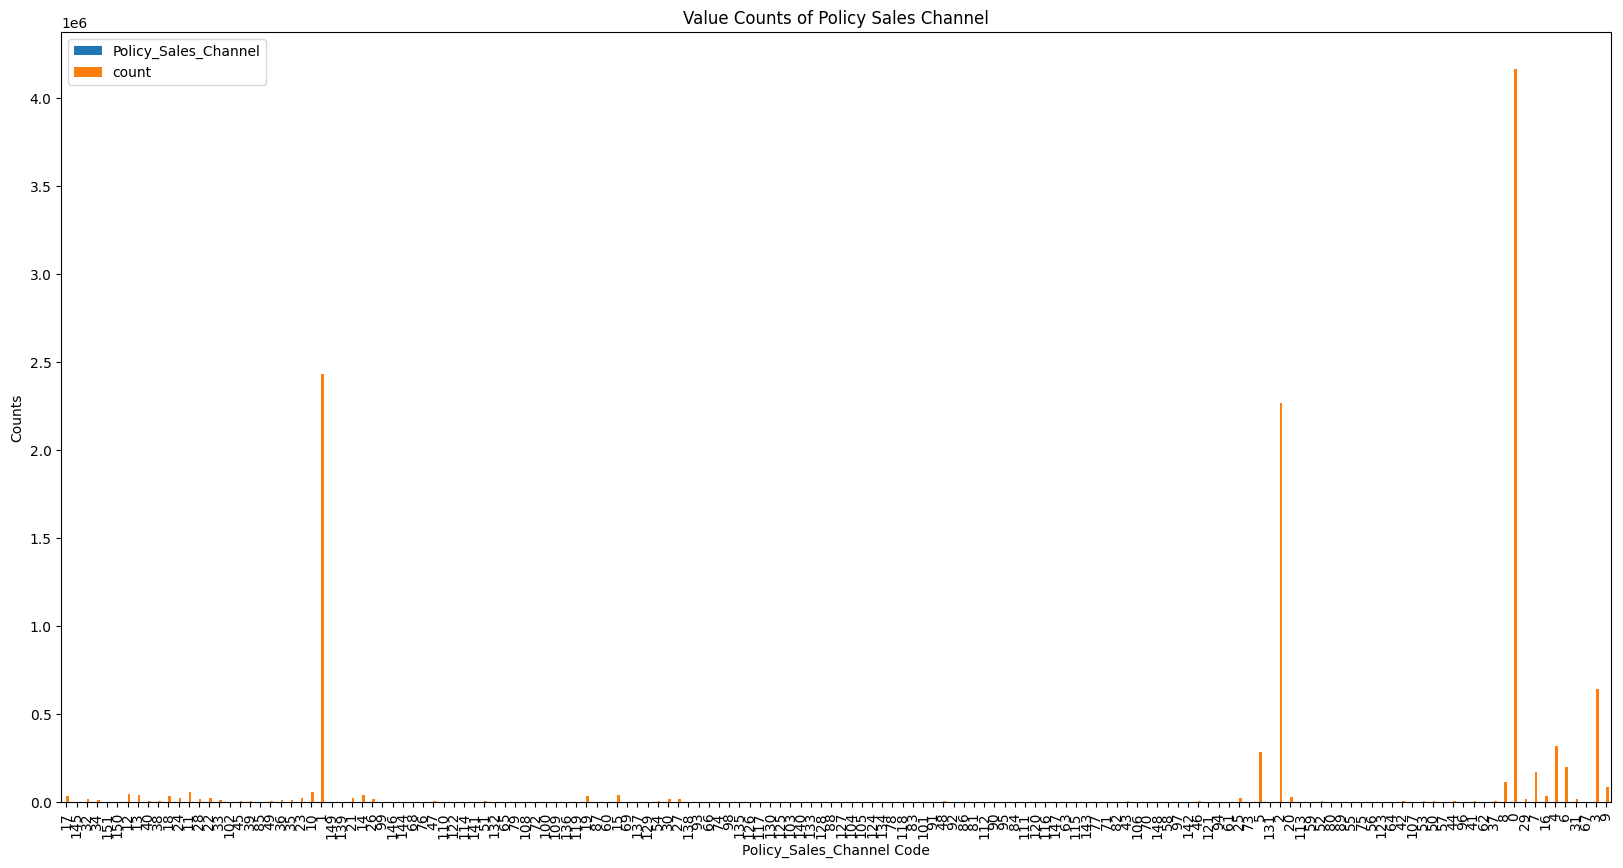

In [28]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
train['Policy_Sales_Channel'].value_counts().reset_index().sort_values(by='Policy_Sales_Channel').plot(kind='bar', ax=ax)
plt.xlabel('Policy_Sales_Channel Code')
plt.ylabel('Counts')
plt.title('Value Counts of Policy Sales Channel')
plt.show()

Same as was with region, some values are mentioned many times, and some almost never. That can affect our model.

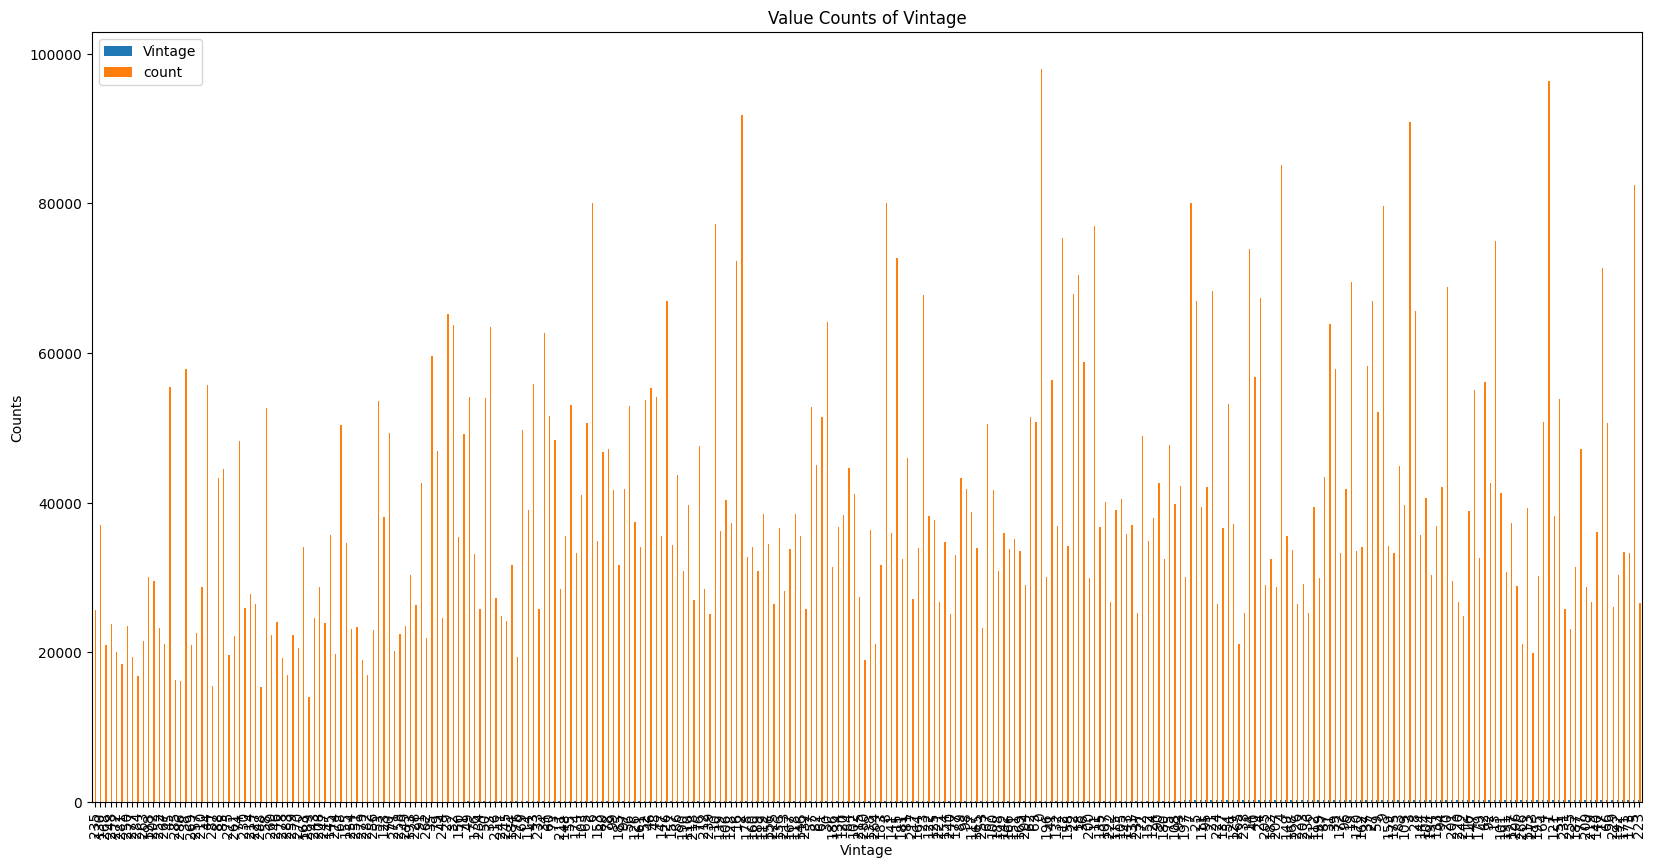

In [29]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
train['Vintage'].value_counts().reset_index().sort_values(by='Vintage').plot(kind='bar', ax=ax)
plt.xlabel('Vintage')
plt.ylabel('Counts')
plt.title('Value Counts of Vintage')
plt.show()

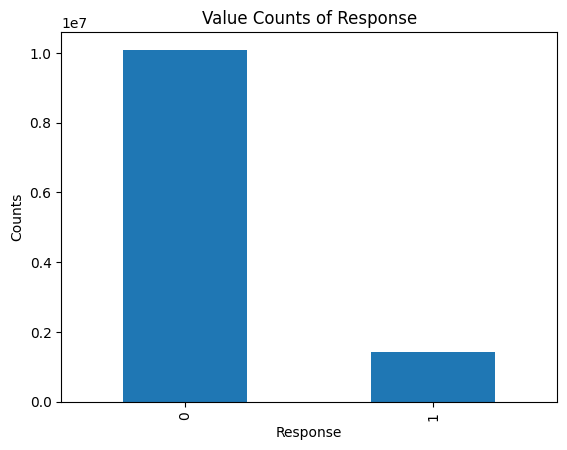

In [30]:
train['Response'].value_counts().plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Counts')
plt.title('Value Counts of Response')
plt.show()

Note that class 1 is highly underrepresented. We may want to apply oversampling later.

### Data Correlation

Let's look at the correlation of features and target variable.

In [31]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


#### Gender

In [32]:
contingency_table = pd.crosstab(train['Gender'], train['Response'])
print(contingency_table)

Response        0       1
Gender                   
Female    4730763  544876
Male      5357142  869710


In [36]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-Square statistic: {chi2}, p-value: {p}")

Chi-Square statistic: 35063.098283802836, p-value: 0.0


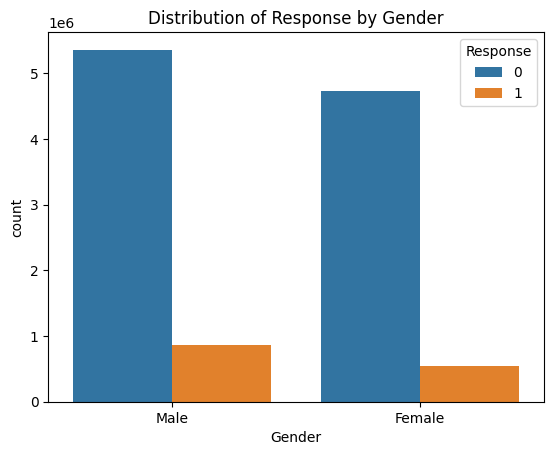

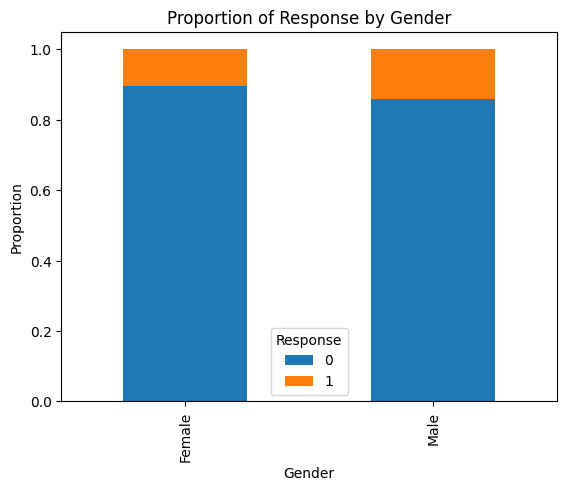

In [37]:
sns.countplot(x='Gender', hue='Response', data=train)
plt.title('Distribution of Response by Gender')
plt.show()

contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
contingency_table_normalized.plot(kind='bar', stacked=True)
plt.title('Proportion of Response by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.show()

From the plots we can see, that there is an insignificant difference between Responses to Male and Female. So this feature is useful, we should definitely leave it.

#### Age

In [40]:
descriptive_stats = train.groupby('Response')['Age'].describe()
print(descriptive_stats)

               count       mean        std   min   25%   50%   75%   max
Response                                                                
0         10087905.0  37.696891  15.297674  20.0  24.0  33.0  49.0  85.0
1          1414586.0  43.272295  11.477025  20.0  35.0  43.0  50.0  83.0


From the descriptive statistics we can see, that for Response 1 Age values are higher and less deviated from the mean.

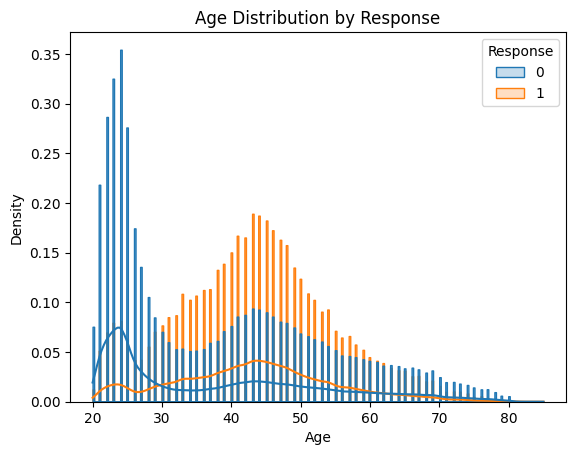

In [42]:
sns.histplot(data=train, x='Age', hue='Response', kde=True, element='step', stat='density', common_norm=False)
plt.title('Age Distribution by Response')
plt.show()

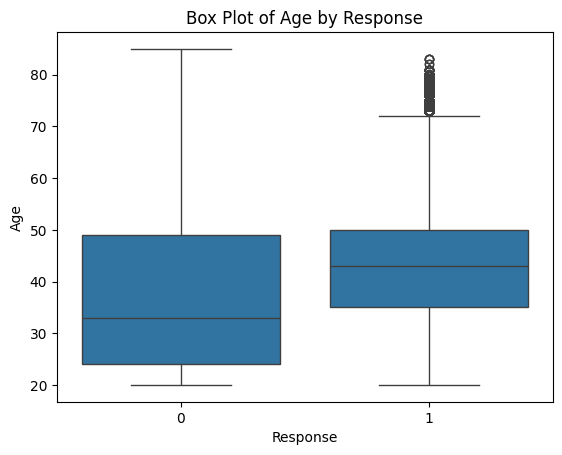

In [43]:
sns.boxplot(x='Response', y='Age', data=train)
plt.title('Box Plot of Age by Response')
plt.show()

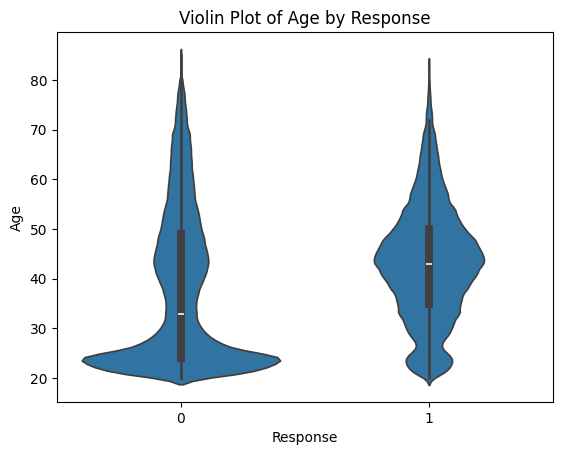

In [44]:
sns.violinplot(x='Response', y='Age', data=train)
plt.title('Violin Plot of Age by Response')
plt.show()

From these plots we can confirm, that Age has a high influence on the target.

#### Driving License

In [45]:
contingency_table = pd.crosstab(train['Driving_License'], train['Response'])
print(contingency_table)

Response                0        1
Driving_License                   
0                   21480     1254
1                10066425  1413332


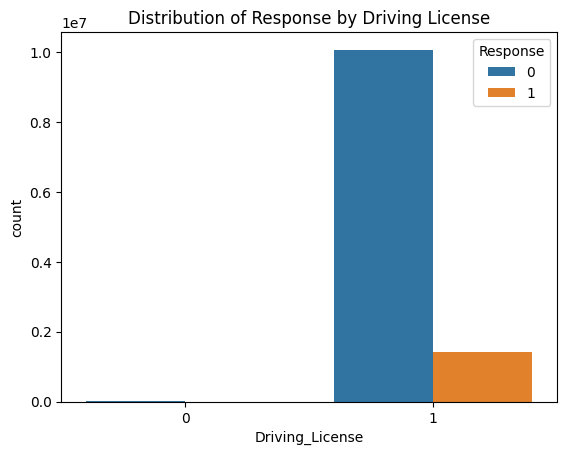

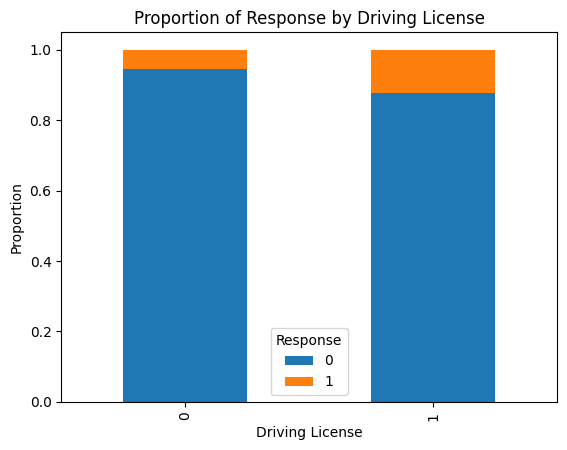

In [46]:
sns.countplot(x='Driving_License', hue='Response', data=train)
plt.title('Distribution of Response by Driving License')
plt.show()

contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
contingency_table_normalized.plot(kind='bar', stacked=True)
plt.title('Proportion of Response by Driving License')
plt.xlabel('Driving License')
plt.ylabel('Proportion')
plt.show()

First we should see, that number of instances without Driving License is very low. Also, this feature has some influence on the target, as all previous ones.

In [47]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


#### Region

In [50]:
contingency_table = pd.crosstab(train['Region_Code'], train['Response'])

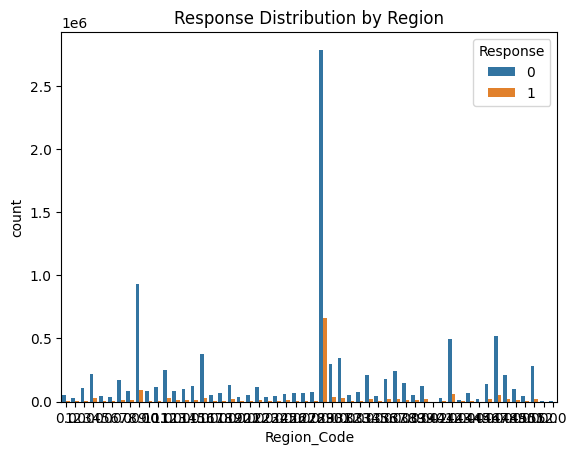

In [52]:
sns.countplot(x='Region_Code', hue='Response', data=train)
plt.title('Response Distribution by Region')
plt.show()

In [54]:
contingency_table['0_Proportion'] = contingency_table[0] / (contingency_table[0] + contingency_table[1])
contingency_table['1_Proportion'] = contingency_table[1] / (contingency_table[0] + contingency_table[1])

In [57]:
contingency_table.describe()

Response,0,1,0_Proportion,1_Proportion
count,5.400000e+01,54.000000,54.000000,54.000000
mean,1.868131e+05,26196.037037,0.902594,0.097406
std,3.944296e+05,89634.092855,0.038226,0.038226
min,1.000000e+00,0.000000,0.808206,0.000000
25%,4.758900e+04,4565.750000,0.883860,0.071651
50%,8.167650e+04,8683.000000,0.910201,0.089799
75%,1.740102e+05,19220.250000,0.928349,0.116140
max,2.788145e+06,661648.000000,1.000000,0.191794


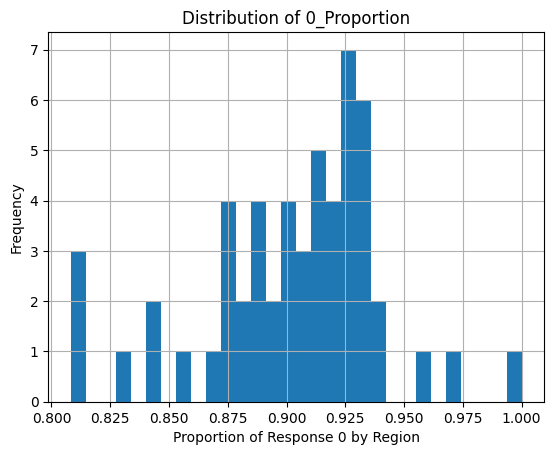

In [58]:
contingency_table['0_Proportion'].hist(bins=30)
plt.xlabel('Proportion of Response 0 by Region')
plt.ylabel('Frequency')
plt.title('Distribution of 0_Proportion')
plt.show()

We can see that there is a difference between percentage of Response 0 in different regions. So Region also influence the decision in some way. However, this plot is highly dependent on the number of instances per Region.

#### Previously Insured

In [60]:
contingency_table = pd.crosstab(train['Previously_Insured'], train['Response'])
print(contingency_table)

Response                  0        1
Previously_Insured                  
0                   4765466  1411186
1                   5322439     3400


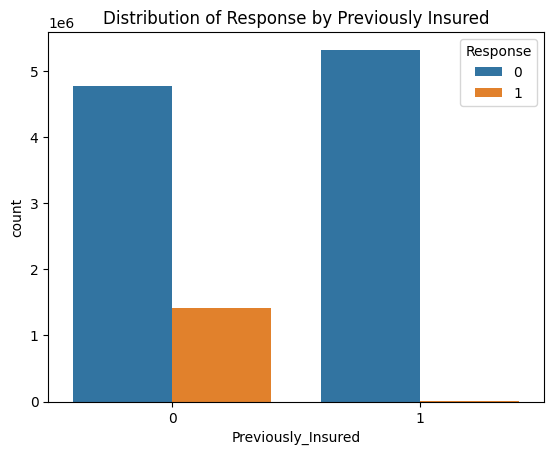

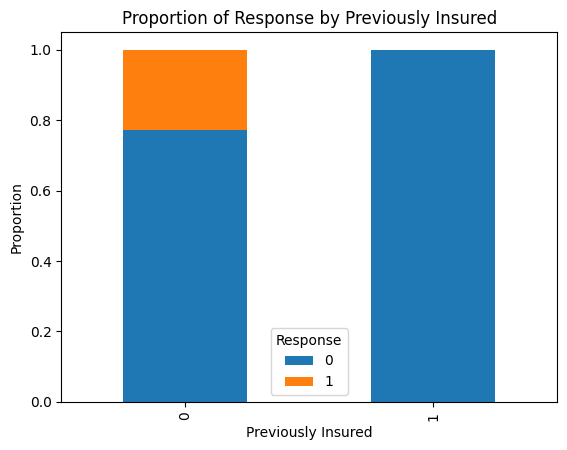

In [61]:
sns.countplot(x='Previously_Insured', hue='Response', data=train)
plt.title('Distribution of Response by Previously Insured')
plt.show()

contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
contingency_table_normalized.plot(kind='bar', stacked=True)
plt.title('Proportion of Response by Previously Insured')
plt.xlabel('Previously Insured')
plt.ylabel('Proportion')
plt.show()

There are very few instances who have both Previously Insured and Response equal to 1. So this feature may be one of the most useful.

#### Vehicle Age

In [62]:
contingency_table = pd.crosstab(train['Vehicle_Age'], train['Response'])
print(contingency_table)

Response           0        1
Vehicle_Age                  
1-2 Year     4918357  1062940
< 1 Year     4834647   208789
> 2 Years     334901   142857


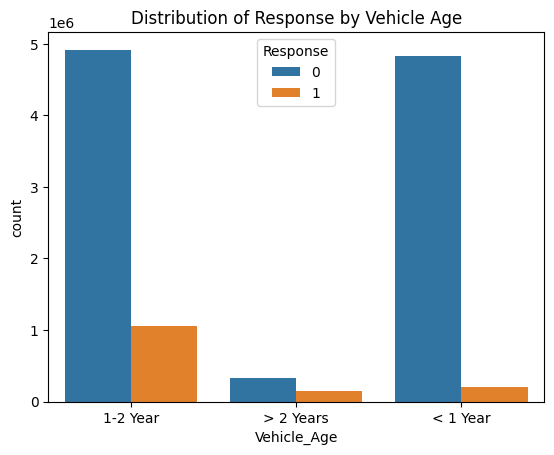

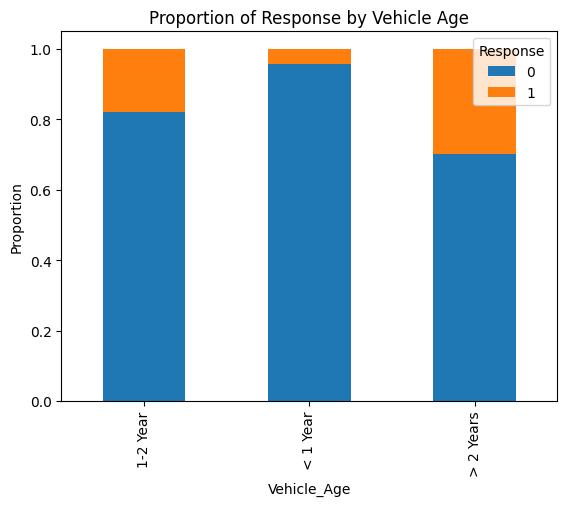

In [63]:
sns.countplot(x='Vehicle_Age', hue='Response', data=train)
plt.title('Distribution of Response by Vehicle Age')
plt.show()

contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
contingency_table_normalized.plot(kind='bar', stacked=True)
plt.title('Proportion of Response by Vehicle Age')
plt.xlabel('Vehicle_Age')
plt.ylabel('Proportion')
plt.show()

Higher the Age of the Vehicle, the more is chance for Response to be 1.

In [64]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


#### Vehicle Damage

In [65]:
contingency_table = pd.crosstab(train['Vehicle_Damage'], train['Response'])
print(contingency_table)

Response              0        1
Vehicle_Damage                  
No              5696657    24016
Yes             4391248  1390570


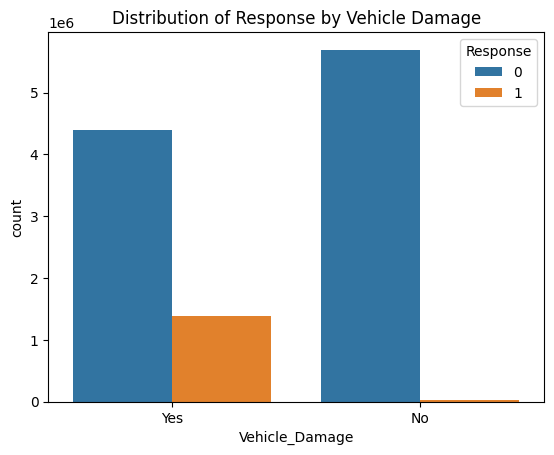

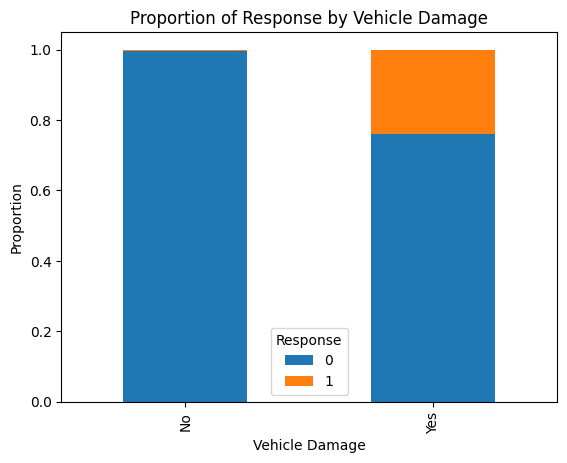

In [66]:
sns.countplot(x='Vehicle_Damage', hue='Response', data=train)
plt.title('Distribution of Response by Vehicle Damage')
plt.show()

contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
contingency_table_normalized.plot(kind='bar', stacked=True)
plt.title('Proportion of Response by Vehicle Damage')
plt.xlabel('Vehicle Damage')
plt.ylabel('Proportion')
plt.show()

Once again, we see significant difference.

#### Annual Premium

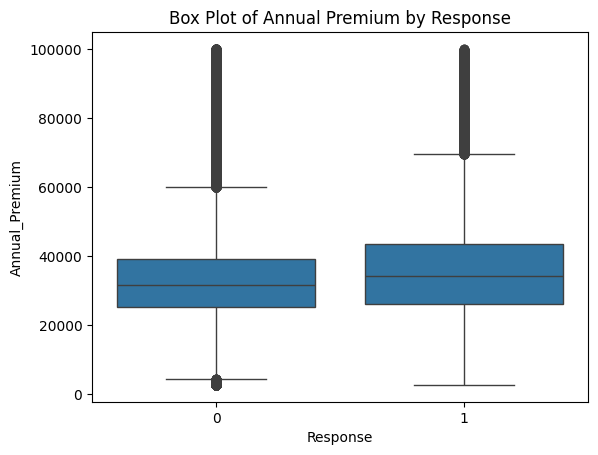

In [67]:
sns.boxplot(x='Response', y='Annual_Premium', data=train)
plt.title('Box Plot of Annual Premium by Response')
plt.show()

Annual Premium is pretty similar for both responses. But for Response 1 it has a bit higher variance.

#### Policy Sales Channel

In [68]:
contingency_table = pd.crosstab(train['Policy_Sales_Channel'], train['Response'])

In [69]:
contingency_table['0_Proportion'] = contingency_table[0] / (contingency_table[0] + contingency_table[1])
contingency_table['1_Proportion'] = contingency_table[1] / (contingency_table[0] + contingency_table[1])

In [70]:
contingency_table.describe()

Response,0,1,0_Proportion,1_Proportion
count,1.520000e+02,152.000000,152.000000,152.000000
mean,6.636780e+04,9306.486842,0.874376,0.125624
std,3.938724e+05,54991.417836,0.119415,0.119415
min,1.000000e+00,0.000000,0.166667,0.000000
25%,8.100000e+01,8.750000,0.811944,0.048325
50%,7.290000e+02,90.500000,0.902289,0.097711
75%,5.663250e+03,914.000000,0.951675,0.188056
max,4.056404e+06,505388.000000,1.000000,0.833333


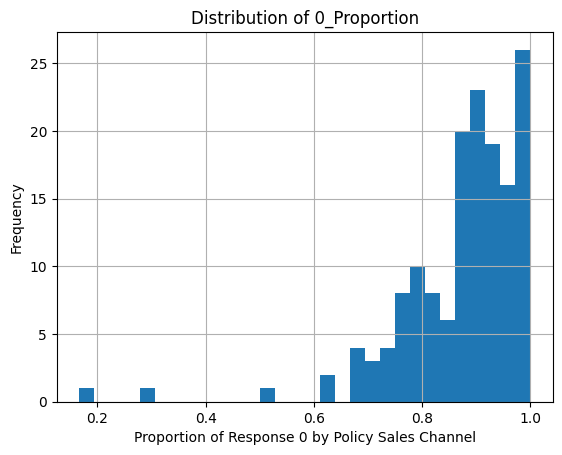

In [71]:
contingency_table['0_Proportion'].hist(bins=30)
plt.xlabel('Proportion of Response 0 by Policy Sales Channel')
plt.ylabel('Frequency')
plt.title('Distribution of 0_Proportion')
plt.show()

Response also depends on Policy Sales Channel.

#### Vintage

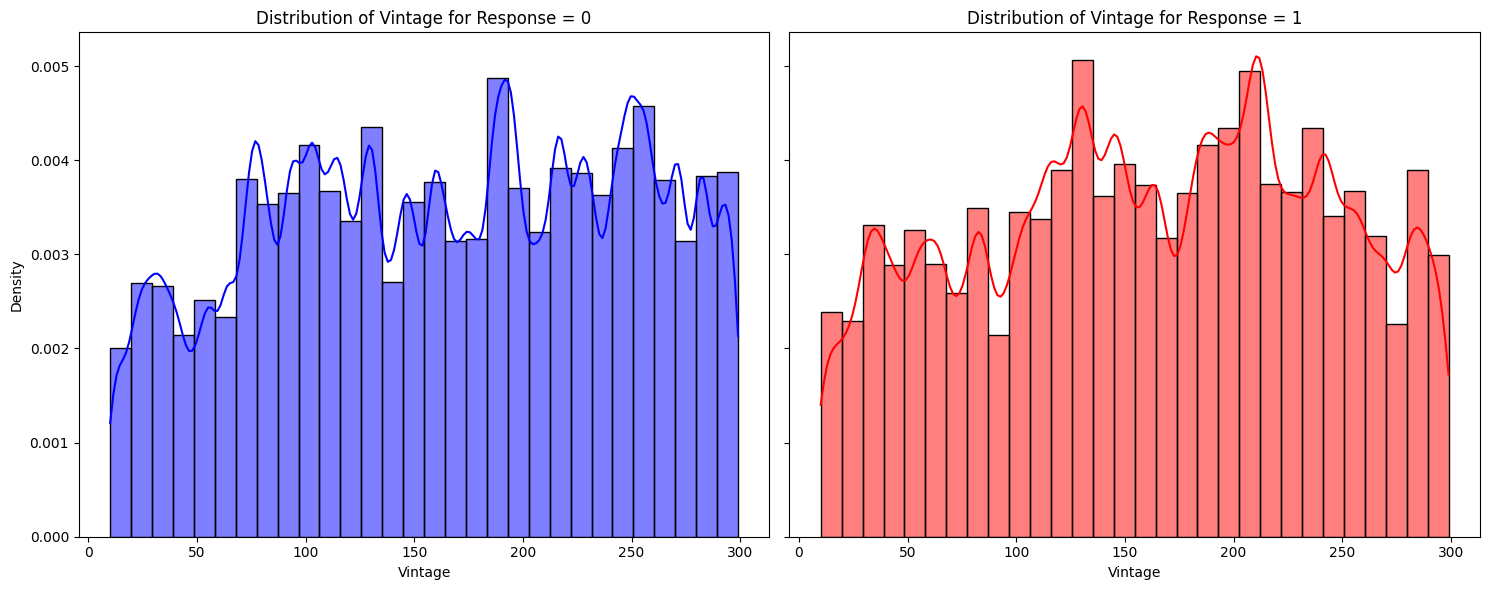

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for Response = 0
sns.histplot(train[train['Response'] == 0]['Vintage'], color='blue', kde=True, bins=30, stat='density', ax=axs[0])
axs[0].set_xlabel('Vintage')
axs[0].set_ylabel('Density')
axs[0].set_title('Distribution of Vintage for Response = 0')

# Plot for Response = 1
sns.histplot(train[train['Response'] == 1]['Vintage'], color='red', kde=True, bins=30, stat='density', ax=axs[1])
axs[1].set_xlabel('Vintage')
axs[1].set_ylabel('Density')
axs[1].set_title('Distribution of Vintage for Response = 1')

plt.tight_layout()
plt.show()

As per these plots, there is no significant difference between 2 distributions. However, I will leave this variable for making predictions.

## Data Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Response', axis=1), train['Response'], test_size=0.2, random_state=42, stratify=train['Response'])

In [18]:
del train

## Dummy Encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Oversampling

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'Male'